# fastai and the New DataBlock API

> A quick glance at the new top-level api

- toc: true
- badges: true
- comments: true
- image: images/chart-preview.png
- category: DataBlock

---

This blog is also a Jupyter notebook available to run from the top down. There will be code snippets that you can then run in any environment. In this section I will be posting what version of `fastai2` and `fastcore` I am currently running at the time of writing this:


* `fastai2`: 0.0.13

* `fastcore`: 0.1.15
---

## What is the `DataBlock` API?

The `DataBlock` API is certainly nothing new to `fastai`. It was here in a lesser form in the previous version, and the start of an *idea*. This idea was: "How do we let the users of the `fastai` library build `DataLoaders` in a way that is simple enough that someone with minimal coding knowledge could get the hang of it, but be advanced enough to allow for exploration." The old version was a struggle to do this from a high-level API standpoint, as you were very limited in what you could do: variables must be passed in a particular order, the error checking wasn't very explanatory (to those unaccustomed to debugging issues), and while the general idea seemed to flow, sometimes it didn't quite work well enough. For our first example, we'll look at the Pets dataset and compare it from `fastai` version 1 to `fastai` version 2

The `DataBlock` itself is built on "building blocks", think of them as legos. (For more information see [fastai: A Layered API for Deep Learning](https://arxiv.org/abs/2002.04688)) They can go in any order but together they'll always build something. Our lego bricks go by these general names:

* `blocks`
* `get_items`
* `get_x`/`get_y`
* `getters`
* `splitter`
* `item_tfms`
* `batch_tfms`

We'll be exploring each one more closely throughout this series, so we won't hit on all of them today

## Importing from the library

The library itself is still split up into modules, similar to the first version where we have Vision, Text, and Tabular. To import from these libraries, we'll be calling their `.all` files. Our example problem for today will involve Computer Vision so we will call from the `.vision` library

In [0]:
from fastai2.vision.all import *

## Pets

Pets is a dataset in which you try to identify one of 37 different species of cats and dogs. To get the dataset, we're going to use functions very familiar to those that used fastai version 1. We'll use `untar_data` to grab the dataset we want. In our case, the Pets dataset lives in `URLs.PETS`

In [0]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz'

In [0]:
path = untar_data(URLs.PETS)

### Looking at the dataset

When starting to look at adapting the API for a particular problem, we need to know just *how* the data is stored. We have an image problem here so we can use the `get_image_files` function to go grab all the file locations of our images and we can look at the data!

In [0]:
fnames = get_image_files(path/'images')

To investigate how the files are named and where they are located, let's look at the first one:

In [0]:
fnames[0]

Path('/root/.fastai/data/oxford-iiit-pet/images/pug_119.jpg')

Now as `get_image_files` grabs the filename of our `x` for us, we don't need to include our `get_x` here (which defaults to `None`) as we just want to use this filepath! Now onto our file paths and how they relate to our labels. If we look at our returned path, this particular image has the class of **pug**. 

Where do I see that? 

**Here**:
Path('/root/.fastai/data/oxford-iiit-pet/images/**pug**_119.jpg')

All the images follow this same format, and we can use a [Regular Expression](https://www.rexegg.com/): to get it out. In our case, it would look something like so:

In [0]:
pat = r'([^/]+)_\d+.*$'

How do we know it worked? Let's apply it to the first file path real quick with `re.search` where we pass in the pattern followed by an item to try and find a match in the first group (set of matches) with a Regular Expression

In [0]:
re.search(pat, str(fnames[0])).group(1)

'pug'

We have our label! So what parts do we have so far? We know how to grab our items (`get_items` and `get_x`), our labels (`get_y`), what's left? Well, we'll want some way to split our data and our data augmentation. Let's focus on the prior.

### Splitting and Augmentation

Any time we train a model, the data must be split between a training and validation dataset. The general idea is that the training dataset is what the model adjusts and fits its weights to, while the validation set is for us to understand how the model is performing. `fastai2` has a family of split functions to look at that will slowly get covered throughout these blogs. For today we'll randomly split our data so 80% goes into our training set and 20% goes into the validation. We can utilize `RandomSplitter` to do so by passing in a percentage to split by, and optionally a seed as well to get the same validation split on multiple runs

In [0]:
splitter = RandomSplitter(valid_pct=0.2, seed=42)

How is this splitter applied? The splitter itself is a function that we can then apply over some set of data or numbers (an array). It works off of indexes. What does that look like? Let's see:

In [0]:
splitter(fnames)

((#5912) [5643,5317,5806,3460,613,5456,2968,3741,10,4908...],
 (#1478) [4512,4290,5770,706,2200,4320,6450,501,1290,6435...])

That doesn't look like filenames! Correct, instead its the **location** in our list of filenames and what group it belongs to. What this special looking list (or `L`) also tells us is how many *items* are in each list. In this example, the first (which is our training data) has 5,912 samples and the second (which is our validation) contains 1,478 samples.

Now let's move onto the augmentation. As noted earlier, there are two kinds: `item_tfms` and `batch_tfms`. Each do what it sounds like: an item transform is applied on an individual item basis, and a batch transform is applied over each batch of data. The role of the item transform is to prepare everything for a batch level (and to apply any specific item transformations you need), and the batch transform is to further apply any augmentations on the batch level efficently (normalization of your data also happens on a batch level). One of the **biggest** differences between the two though is *where* each is done. Item transforms are done on the **CPU** while batch transforms are performed on the **GPU**. 

Now that we know this, let's build a basic transformation pipeline that looks something like so: 
1. Resize our images to a fixed size (224x224 pixels)
2. After they are batched together, choose a quick basic augmentation function
3. Normalize all of our image data

Let's build it!

In [0]:
item_tfms = [Resize(224, method='crop')]
batch_tfms=[*aug_transforms(size=256), Normalize.from_stats(*imagenet_stats)]

Woah, woah, woah, what in the world is this `aug_transforms` thing you just showed me I hear you ask? It runs a series of augmentations similar to the `get_transforms()` from version 1. The entire list is quite exhaustive and we'll discuss it in a later blog, but for now know we can pass in an image size to resize our images to (we'll make our images a bit larger, doing 256x256).

Alright, we know how we want to get our data, how to label it, split it, and augment it, what's left? That `block` bit I mentioned before. 

### The `Block`

`Block`'s are used to help nest transforms inside of pre-defined problem domains. 

Lazy-man's explaination? 

If it's an image problem I can tell the library to use `Pillow` without explicitly saying it, or if we have a Bounding Box problem I can tell the DataBlock to expect two coordinates for boxes and to apply the transforms for points, again without explicitly saying these transforms. 

What will we use today? Well let's think about our problem: we are using an image for our `x`, and our labels (or `y`'s) are some category. Is there blocks for this? Yes! And they're labeled `ImageBlock` and `CategoryBlock`! Remember how I said it just "made more sense?" This is a direct example. Let's define them:

In [0]:
blocks = (ImageBlock, CategoryBlock)

## Now let's build this `DataBlock` thing already!

Alright we have all the pieces now, let's see how they fit together. We'll all wrap them up in a nice little package of a `DataBlock`. Think of the `DataBlock` as a list of instructions to do when we're building batches and our `DataLoaders`. It doesn't need any items explicitly  to be done, and instead is a blueprint of how to operate. We define it like so:

In [0]:
block = DataBlock(blocks=blocks,
                  get_items=get_image_files,
                  get_y=RegexLabeller(pat),
                  splitter=splitter,
                  item_tfms=item_tfms,
                  batch_tfms=batch_tfms)

Once we have our `DataBlock`, we can build some `DataLoaders` off of it. To do so we simply pass in a source for our data that our `DataBlock` would be expecting, specifically our `get_x` and `get_y`, so we'll follow the same idea we did above to get our filenames and pass in a path to the folder we want to use along with a batch size:

In [0]:
dls = block.dataloaders(path, bs=64)

While it's a bit long, you can understand why we had to define everything the way that we did. If you're used to how fastai v1 looked with the `ImageDataBunch.from_x`, well this is stil here too:

In [0]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, item_tfms=item_tfms,
                                            batch_tfms=batch_tfms, bs=64)

I'm personally a much larger fan of the first example, and if you're planning on using the library quite a bit you should get used to it more as well! This blog series will be focusing on that nomenclature specifically. To make sure everything looks okay and we like our augmentation we can show a batch of images from our `DataLoader`. It's as simple as:

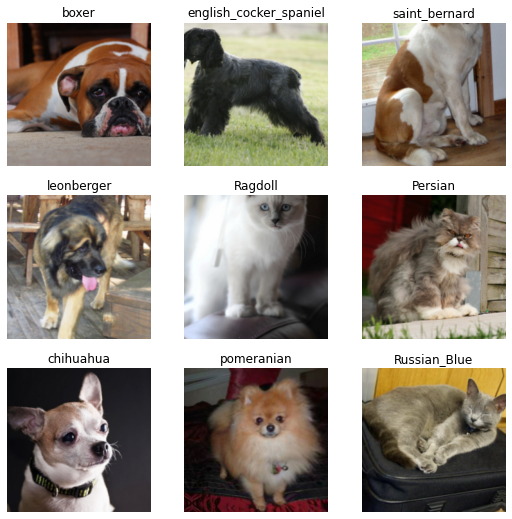

In [0]:
dls.show_batch()

## Fitting a Model

Now from here everything looks and behaves exactly how it did in `fastai` version 1:
1. Define a `Learner`
2. Find a learning rate
3. Fit

We'll quickly see that `fastai2` has a quick function for transfer learning problems like we are doing, but first let's build the `Learner`. This will use `cnn_learner`, as we are doing transfer learning, and we'll tell the function to use a `resnet34` architecture with accuracy metrics

In [0]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)

Now normally we would do `learn.lr_find()` and find a learning rate, but with the new library, we now have a `fine_tune()` function we can use instead specifically designed for transfer learning scenarios. It runs a specified number of epochs (the number of times we fully go through the dataset) on a frozen model (where all but the last layer's weights are not trainable) and then the last few will be on an unfrozen model (where all weights are trainable again). When just passing in one set of epochs, like below, it will run frozen for one and unfrozen for the rest. Let's try it!

In [0]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,1.488222,0.331919,0.893099,00:42


epoch,train_loss,valid_loss,accuracy,time
0,0.471458,0.363768,0.890392,00:43
1,0.368975,0.250430,0.926252,00:43
2,0.205113,0.215602,0.935047,00:44


As we can see we did pretty goood just with this default! Generally when the accuracy is this high, we want to turn instead to `error_rate` for our metric, as this would show ~6.5% and is a better comparison when it gets very fine tuned. 

But that's it for this first introduction! We looked at how the Pets dataset can be loaded into the new high-level `DataBlock` API, and what it's built with. In the next blog we will be exploring more variations with the `DataBlock` as we get more and more creative. Thanks for reading!